# Stock Sentiment Analysis with News Headlines

<br /><br />
More and more hedge funds and independent traders are utilizing data science to process the wealth of information available from news headlines in the quest for profit. In this project, I will generate investment insights by applying sentiment analysis on financial news headlines, webscraped from FINVIZ.com. Repsecting data science ethics with regard to webscraping, I have downloaded various HTML files for two large firms: Facebook & Tesla.

Through conducting sentiment analysis, we can examine the emotion behind the headlines and predict whether the market feels good or bad about a stock. Then, we can make educated guesses on how certain stocks will perform and trade accordingly. Below, we import these files:
<br />

In [46]:
# import libraries
from bs4 import BeautifulSoup
import os

html_tables = {}

# for every data set in os dataset folder
for table_name in os.listdir('datasets'):
    # filepath
    table_path = f'datasets/{table_name}'

    # open as read-only, read into 'html'
    table_file = open(table_path, 'r')
    html = BeautifulSoup(table_file)

    # add news-table to 'html_tables' dictionary
    html_table = html.find(id = 'news-table')
    html_tables[table_name] = html_table


<br /><br />
We've now obtained the table which contains all the headlines from each stock's HTML file. Before we move any further, we must investigate the structure in the data table. Let's read a single day of headlines for Tesla. 
<br />

In [ ]:
tsla = html_tables['tsla_22sep.html']

# store all table rows with <tr> tags
tsla_tr = tsla.findAll('tr')

for i, table_row in enumerate(tsla_tr) :

    # store <a> elements in link_text
    link_text = table_row.a.get_text()
    # store <td> elements in data_text
    data_text = table_row.a.get_text()

    # print file count & text variables
    print(f'File number {i+1}:'); print(link_text); print(data_text)

    # exits loop after 4 rows
    if i == 3: break

<br />Now, we're ready to parse the data for <strong>all</strong> tables into a list.<br />

In [48]:
# parsed news list of lists
parsed_news = []
# Iterate through news, nested iterate through all tr tags in each "news_table"
for file_name, news_table in html_tables.items():
    for x in news_table.findAll('tr'):
        # store read text in 'text'
        text = x.get_text() 
        # scrape the text, split into a list
        date_scrape = x.td.text.split()
        
        # if date_scrape only has 1 element, only load 'time'
        if len(date_scrape) == 1:
            time = date_scrape[0]
        # otherwise, load both 'date' and 'time'
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        # extract stock ticker 
        stock_ticker = file_name.split("_")[0]

        # append all our information: ticker, date, time, headline
        parsed_news.append([stock_ticker, date, time, x.a.text])

<br /><br />
Sentiment Analysis is very sensitive to context. For example, saying "This is so addicting." can be a positive statement when describing an exciting thing, like a video game, but can also be negative when we're talking about drugs. Like most professionals, financial journalists have their own writing style, so to extract sentiment from their headlines, must make NLTK think like a financial journalist. Let's add some keywords and sentiment values to our program.
<br />

In [ ]:
# NLTK VADER for sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

# words and values
keywords = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# instantiate sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()
# update the lexicon
vader.lexicon.update(keywords)

<br /><br />We now have the data and the sentiment algorithm loaded, our next step is to programmatically predict sentiment out of news headlines. VADER is very high level; we do not require to adjust the model any further. We can proceed by converting our 'parsed_news' list of lists into a pandas DataFrame, and joining it with another DataFrame, containing the polarity scores for all headlines.<br />

In [141]:
import pandas as pd

columns = ['ticker', 'date', 'time', 'headline']

# convert parsed_news into pandas DataFrame
scored_news_df = pd.DataFrame(parsed_news, columns=columns)

# get polarity scores from each headline
scores = [vader.polarity_scores(headline) for headline in scored_news_df.headline]

# convert scores into DataFrame
scores_df = pd.DataFrame(scores)
scored_news_df.columns = columns

# join scored_news_df and scores_df
scored_news_df = scored_news_df.join(scores_df)

<br /><br />We have obtained the scores, so it's time to plot the results. The first step is to plot the time series for the stocks.<br />

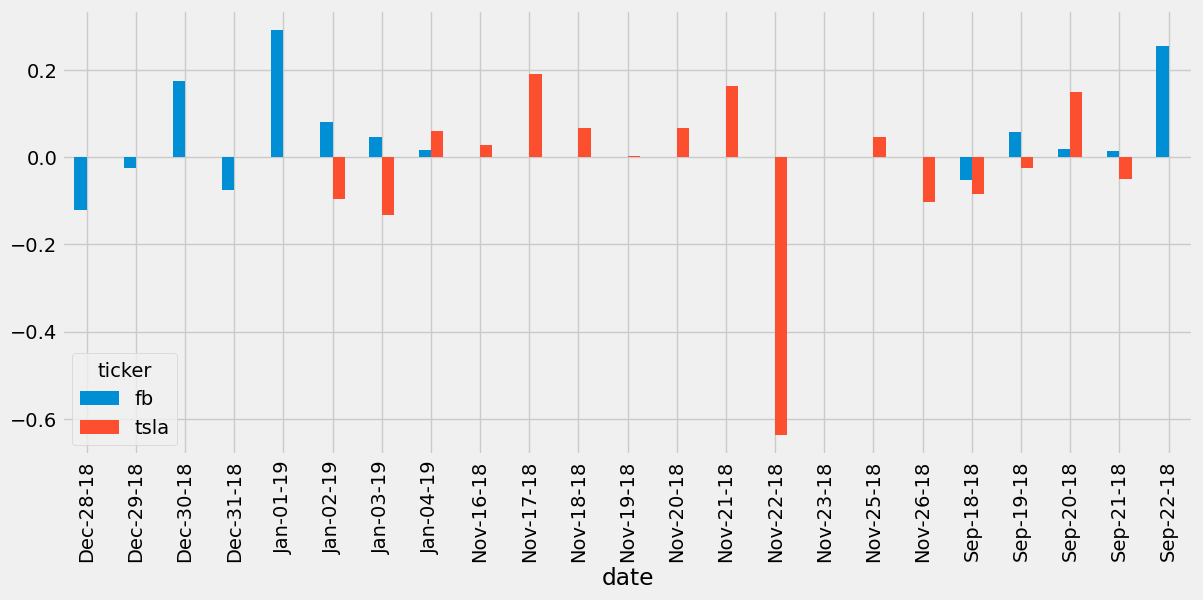

In [142]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%matplotlib inline

# calculate the mean
mean_c = scored_news_df.groupby(['date', 'ticker']).mean()

# unstack the column ticker
mean_c = mean_c.unstack('ticker')

# get the cross-section of compound in the 'columns' axis
mean_c = mean_c.xs("compound", axis="columns")

# plot a bar chart with pandas
mean_c.plot.bar(figsize = (13, 5.5));

<br /><br />What happened to Tesla on November 22nd? A quick peek inside the DataFrame reveals that there are only 5 headlines and two headlines are verbatim the same as the other but from another news outlet, on that day. The fact that identical headlines could result in different articles, could result in inconsistent perspectives on the same story. Plus, when one piece of news is more important, it tends to get more headlines from multiple sources. We want to get rid of these verbatim copied headlines, as these probably come from the same journalist. 

In [143]:
# count number of headlines before removing duplicates
num_news_before = scored_news_df.headline.count()

# drop duplicates based on ticker and headline
scored_news_clean = scored_news_df.drop_duplicates(subset=['headline', 'ticker'])

# count number of headlines after removing duplicates
num_news_after = scored_news_clean.headline.count()

# print before/after numbers to see how many we removed
f"Before we had {num_news_before} headlines, now we have {num_news_after}"

'Before we had 500 headlines, now we have 476'

<br /> <br />Just to understand the possibilities of this dataset and get a better feel of the data, let's focus on one trading day and one single stock: namely, Facebook's stock on January 03, 2019. We will make an informative plot where we will see the smallest grain possible: headline and subscores.

In [144]:
# set the index to ticker and date
single_day = scored_news_clean.set_index(['ticker', 'date'])

# cross-section the facebook row
single_day = single_day.xs('fb')

# select jan 03, 2019
single_day = single_day.loc['Jan-03-19']

# convert single_day time string to time
single_day['time'] = pd.to_datetime(single_day['time']).dt.time

# set the index to time and sort...
single_day = single_day.set_index('time')
single_day = single_day.sort_index()

<br /><br />

Below is a plot to visualize the positive, negative, and neutral scores for a single day of trading (Jan 03, 2019) and a single stock (Facebook). This is one of the many ways to visualize this dataset, and might be useful for day traders. 

C:\Users\danie\AppData\Local\Temp\ipykernel_7724\626611611.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  plot_day = single_day.drop(['compound', 'headline'], 1)


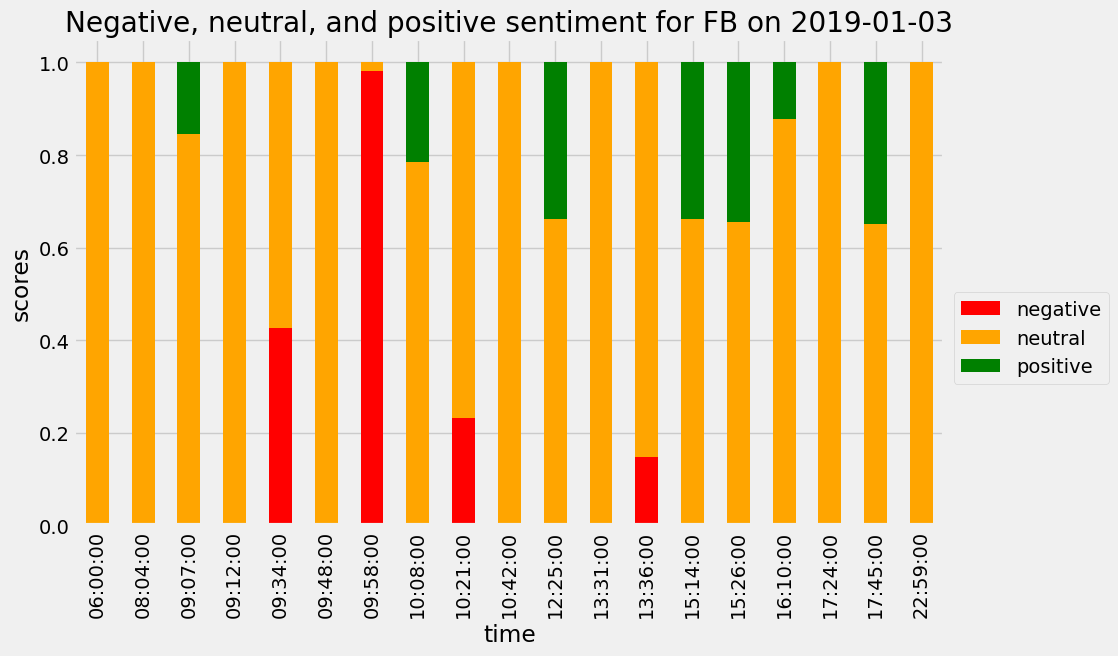

In [146]:
TITLE = "Negative, neutral, and positive sentiment for FB on 2019-01-03"
COLORS = ["red","orange", "green"]\

# drop useless columns
plot_day = single_day.drop(['compound', 'headline'], 1)

# change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative', 'neutral', 'positive']

# plot stacked bar chart
plot_day.plot.bar(stacked = True, figsize=(10, 6), title = TITLE, color = COLORS).legend(bbox_to_anchor=(1.2, 0.5))
plt.ylabel("scores");